# Vanilla AutoEncoder Example with CIFAR10

# Imports

In [1]:
import torch, torchvision, time
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(547)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Configurations

In [2]:
EPOCHS = 5
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 0

# Dataloader and Pre-processing

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Model

### Encoder

In [4]:
class encoder(nn.Module):
    def __init__(self, in_channel=3):
        super(encoder, self).__init__()
        self.down_sample1 = nn.Conv2d(in_channels=in_channel, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.down_sample2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.down_sample3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.down_sample4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.down_sample5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64*4*4, latent_dim)
        
    def forward(self, x):
        #print(f"x: {x.shape}")
        x = self.down_sample1(x)
        #print(f"down_sample1: {x.shape}")
        x = self.relu1(x)
        
        x = self.down_sample2(x)
        #print(f"down_sample2: {x.shape}")
        x = self.relu2(x)
        
        x = self.down_sample3(x)
        #print(f"down_sample3: {x.shape}")
        x = self.relu3(x)
        
        x = self.down_sample4(x)
        #print(f"down_sample4: {x.shape}")
        x = self.relu4(x)
        
        x = self.down_sample5(x)
        #print(f"down_sample5: {x.shape}")
        out = self.relu5(x)
        
        return out
        

### Decoder

In [5]:
class decoder(nn.Module):
    def __init__(self, in_channels=8):
        super(decoder, self).__init__()
        self.up_sample1 = nn.ConvTranspose2d(in_channels=64, out_channels= 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.up_sample2 = nn.ConvTranspose2d(in_channels=32, out_channels= 32, kernel_size=3, stride=1, padding=1, output_padding=0)
        self.relu2 = nn.ReLU(inplace=True)
        self.up_sample3 = nn.ConvTranspose2d(in_channels=32, out_channels= 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.up_sample4 = nn.ConvTranspose2d(in_channels=16, out_channels= 16, kernel_size=3, stride=1, padding=1, output_padding=0)
        self.relu4 = nn.ReLU(inplace=True)
        self.up_sample5 = nn.ConvTranspose2d(in_channels=16, out_channels= 3,  kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = self.up_sample1(x)
        #print(f"up_sample1: {x.shape}")
        x = self.relu1(x)
        
        x = self.up_sample2(x)
        #print(f"up_sample2: {x.shape}")
        x = self.relu2(x)
        
        x = self.up_sample3(x)
        #print(f"up_sample3: {x.shape}")
        x = self.relu3(x)
        
        x = self.up_sample4(x)
        #print(f"up_sample4: {x.shape}")
        x = self.relu4(x)
        
        out = self.up_sample5(x)
        #print(f"up_sample5: {x.shape}")
        
        return out

### AutoEncoder

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = encoder()
        self.fc1 = nn.Linear(64*4*4, 8)
        self.fc2 = nn.Linear(8, 64*4*4)
        self.relu = nn.ReLU(inplace=True)
        self.decoder = decoder()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.encoder(x)
        #print(f"encoder: {x.shape}")
        x = x.view(x.shape[0], -1)
        #print(f"x: {x.shape}")
        x = self.fc1(x)
        #print(f"fc1: {x.shape}")
        x = self.fc2(x)
        #print(f"fc2: {x.shape}")
        x = x.reshape(x.shape[0], -1, 4, 4)
        #print(f"x: {x.shape}")
        x = self.decoder(x)
        #print(f"decoder: {x.shape}")
        out = self.sigmoid(x)
        
        return out
        
model = autoencoder().to(device)

# Loss and Optimizer

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,12,15], gamma=0.1)

# Training

In [8]:
outputs = []
losses = []
for epoch in range(EPOCHS):
    running_train_loss = 0
    start_time = time.time()
    for image, target in train_loader:
        image, _ = image.to(device), target.to(device)
        
        output = model(image)
        loss = criterion(output, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    outputs.append((epoch+1, image[0], output[0]))
    loss = running_train_loss / len(train_loader)
    losses.append(loss)
    end_time = time.time()
    #scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], loss:{loss:.4f} in {(end_time-start_time):.2f}s")

Epoch [1/5], loss:0.0280 in 9.37s
Epoch [2/5], loss:0.0239 in 9.14s
Epoch [3/5], loss:0.0230 in 9.14s
Epoch [4/5], loss:0.0228 in 9.10s
Epoch [5/5], loss:0.0227 in 9.11s


# Evaluation

loss: 0.02517
Original Images


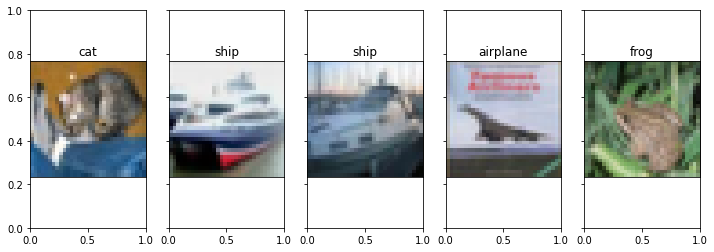

Reconstructed Images


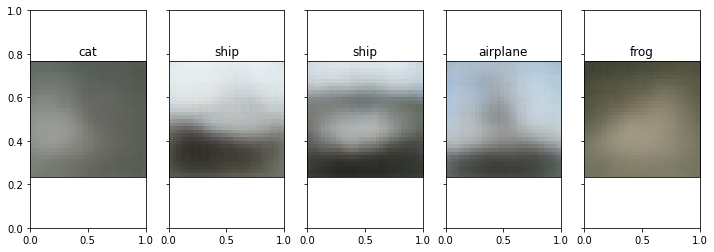

In [9]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.to(device))
print(f"loss: {criterion(images.to(device), output.to(device)):.5f}")
images = images.permute(0, 2, 3, 1).numpy()
output = output.cpu().permute(0, 2, 3, 1).detach().numpy()
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 